In [194]:
import SimFunctions
import SimClasses
import SimRNG
import SimRNG_Modified
import simpy
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import probplot, kstest
import pickle
warnings.filterwarnings("ignore")
# fix random number seed
np.random.seed(1)

ZSimRNG = SimRNG_Modified.InitializeRNSeed()


# Data Loading from BikeShare Data

In [195]:
#subset_df = pd.read_csv("10_station_subset.csv")
subset_df = pd.read_csv("top20_station_subset.csv")


In [196]:
subset_df

,Unnamed: 0,Trip Id,Trip_Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,NumOfTrips,Start Time (per 30min),End Time (per 30min),Start Time (minutes),End Time (minutes)
0,0,17515475,29.566667,7203,2022-08-01 00:02:00,Bathurst St/Queens Quay(Billy Bishop Airport),7261.0,2022-08-01 00:32:00,Queens Quay E / Lower Sherbourne St,6908,Casual Member,72,0.0,1.0,2,32
1,9085,18290269,7.183333,7016,2022-08-31 00:29:00,Bay St / Queens Quay W (Ferry Terminal),7175.0,2022-08-31 00:36:00,HTO Park (Queens Quay W),5229,Annual Member,163,0.0,1.0,29,36
2,72,17515576,8.783333,7171,2022-08-01 00:10:00,Ontario Place Blvd / Lake Shore Blvd W (East),7298.0,2022-08-01 00:19:00,Bathurst St / Adelaide St W,6190,Annual Member,16,0.0,0.0,10,19
3,88,17515603,24.733333,7322,2022-08-01 00:12:00,King St W / Brant St,7076.0,2022-08-01 00:37:00,York St / Queens Quay W,4813,Casual Member,78,0.0,1.0,12,37
4,90,17515629,22.450000,7322,2022-08-01 00:15:00,King St W / Brant St,7076.0,2022-08-01 00:37:00,York St / Queens Quay W,5611,Casual Member,78,0.0,1.0,15,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16197,2378,17852946,16.366667,7298,2022-08-13 23:35:00,Bathurst St / Adelaide St W,7171.0,2022-08-13 23:52:00,Ontario Place Blvd / Lake Shore Blvd W (East),3194,Casual Member,38,47.0,47.0,1415,1432
16198,2379,17852948,16.233333,7298,2022-08-13 23:35:00,Bathurst St / Adelaide St W,7171.0,2022-08-13 23:52:00,Ontario Place Blvd / Lake Shore Blvd W (East),3427,Casual Member,38,47.0,47.0,1415,1432
16199,17241,18216900,14.900000,7030,2022-08-27 23:49:00,Bay St / Wellesley St W,7322.0,2022-08-28 00:04:00,King St W / Brant St,5820,Annual Member,7,47.0,0.0,1429,4
16200,7221,18044530,8.333333,7430,2022-08-20 23:43:00,Marilyn Bell Park Tennis Court,7242.0,2022-08-20 23:52:00,Lake Shore Blvd W / Ontario Dr,5448,Casual Member,240,47.0,47.0,1423,1432


# Arrival Rates

In [197]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by station and 30-minute interval, and count the number of trips that started in each group
Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'],subset_df['Start Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')
#Start_Station_HalfHour_Arrivals = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='ArrivalRate (per 30min)')

# Calculate the arrival rate at each station and 30-minute interval (trips per hour)
Start_Station_HalfHour_Arrivals['ArrivalRate (per min)'] = Start_Station_HalfHour_Arrivals['ArrivalRate (per 30min)'] / 30

# Display the result
arrival_df = Start_Station_HalfHour_Arrivals.sort_values(by="Start Time (per 30min)")
arrival_df


,Start Station Name,Start Station Id,Start Time (per 30min),ArrivalRate (per 30min),ArrivalRate (per min)
0,Bathurst St / Adelaide St W,7298,0.0,7,0.233333
642,Queens Quay W / Lower Simcoe St,7043,0.0,8,0.266667
729,Union Station,7033,0.0,2,0.066667
129,Bay St / Queens Quay W (Ferry Terminal),7016,0.0,9,0.300000
383,Lake Shore Blvd W / Ontario Dr,7242,0.0,8,0.266667
...,...,...,...,...,...
128,Bay St / College St (East Side),7006,47.0,4,0.133333
728,Soho St / Queen St W,7217,47.0,1,0.033333
87,Bathurst St/Queens Quay(Billy Bishop Airport),7203,47.0,25,0.833333
597,Queens Quay / Yonge St,7168,47.0,9,0.300000


In [198]:
desc = arrival_df.describe()[1:2].values
mean_arrival_30 = desc[0][2]
mean_arrival_min = desc[0][3]

customer_per_30min = mean_arrival_30
customer_per_min = mean_arrival_min
print(f"Customers Per 30 min = {customer_per_30min}")
print(f"Customers Per min = {customer_per_min}")


Customers Per 30 min = 19.855392156862745
Customers Per min = 0.6618464052287582


- There is approx 0.10 customer every minute in the dataset or 1 customer every 10min

# Probability of Destinations

In [199]:
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

start_end_station_halfhour_trips = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']]).size().reset_index(name='NumOfTrips')
total_trips = start_end_station_halfhour_trips.groupby(['Start Station Name', 'Start Time (per 30min)'])['NumOfTrips'].sum().reset_index(name='TotalTrips')

start_end_station_prob = pd.merge(start_end_station_halfhour_trips, total_trips, on=['Start Station Name', 'Start Time (per 30min)'])
start_end_station_prob['Probability'] = start_end_station_prob['NumOfTrips'] / start_end_station_prob['TotalTrips']

station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Name', 'Start Time (per 30min)'], columns=['End Station Name'], values='Probability').fillna(0)#.reset_index().fillna(0)
name_prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
name_prob_df


,End Station Name,Bathurst St / Adelaide St W,Bathurst St/Queens Quay(Billy Bishop Airport),Bay St / College St (East Side),Bay St / Queens Quay W (Ferry Terminal),Bay St / Wellesley St W,College St / Major St,Fort York Blvd / Capreol Ct,HTO Park (Queens Quay W),King St W / Brant St,Lake Shore Blvd W / Ontario Dr,Lower Jarvis / Queens Quay E,Marilyn Bell Park Tennis Court,Ontario Place Blvd / Lake Shore Blvd W (East),Queens Quay / Yonge St,Queens Quay E / Lower Sherbourne St,Queens Quay W / Lower Simcoe St,Soho St / Queen St W,Union Station,York St / Queens Quay W
Start Station Name,Start Time (per 30min),,,,,,,,,,,,,,,,,,,
Bathurst St / Adelaide St W,0.0,0.0,0.000000,0.285714,0.000000,0.285714,0.0,0.0,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.285714
Queens Quay W / Lower Simcoe St,0.0,0.0,0.375000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.125,0.00,0.000000,0.375000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000
Union Station,0.0,0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
Bay St / Queens Quay W (Ferry Terminal),0.0,0.0,0.111111,0.000000,0.000000,0.000000,0.0,0.0,0.111111,0.000,0.00,0.111111,0.000000,0.111111,0.000000,0.222222,0.000000,0.000000,0.333333,0.000000
Lake Shore Blvd W / Ontario Dr,0.0,0.0,0.000000,0.125000,0.000000,0.000000,0.0,0.0,0.000000,0.125,0.00,0.000000,0.625000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bay St / College St (East Side),47.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.5,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
Soho St / Queen St W,47.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bathurst St/Queens Quay(Billy Bishop Airport),47.0,0.0,0.000000,0.000000,0.480000,0.000000,0.0,0.0,0.080000,0.000,0.04,0.040000,0.040000,0.000000,0.160000,0.000000,0.040000,0.000000,0.040000,0.080000


Real Probability
End Station Name
Bathurst St / Adelaide St W                      0.000
Bathurst St/Queens Quay(Billy Bishop Airport)    0.000
Bay St / College St (East Side)                  0.125
Bay St / Queens Quay W (Ferry Terminal)          0.000
Bay St / Wellesley St W                          0.000
College St / Major St                            0.000
Fort York  Blvd / Capreol Ct                     0.000
HTO Park (Queens Quay W)                         0.000
King St W / Brant St                             0.125
Lake Shore Blvd W / Ontario Dr                   0.000
Lower Jarvis / Queens Quay E                     0.000
Marilyn Bell Park Tennis Court                   0.625
Ontario Place Blvd / Lake Shore Blvd W (East)    0.000
Queens Quay / Yonge St                           0.000
Queens Quay E / Lower Sherbourne St              0.000
Queens Quay W / Lower Simcoe St                  0.125
Soho St / Queen St W                             0.000
Union Station                  

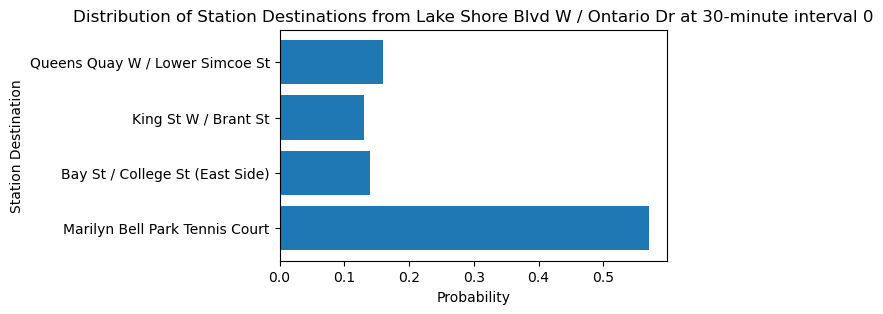

In [200]:
def ChoosingRoute(prob_df, start_station, start_time):
    try:
        start_row = prob_df.loc[(start_station, start_time)]
        probs = start_row.values
        destination = np.random.choice(start_row.index, p=probs)
        return destination
    except KeyError:
        print(
            f"No data found for start station '{start_station}' and start time '{start_time}'")


monte_carlo = []
for i in range(100):
    start_station = 'Lake Shore Blvd W / Ontario Dr'
    start_time = 0  # 30-minute interval index
    destination = ChoosingRoute(name_prob_df, start_station, start_time)
    if destination is not None:
        monte_carlo.append(destination)


prob = {}
for s in monte_carlo:
    if s in prob:
        prob[s] += 1
    else:
        prob[s] = 1
for s in prob:
    prob[s] /= len(monte_carlo)

print("Real Probability")
print(name_prob_df.loc[(start_station, start_time)])
print()
print("Simulated Probability")
print(prob)
# Plot the bar chart
plt.figure(figsize=(5, 3))
plt.barh(list(prob.keys()), list(prob.values()))
plt.xlabel('Probability')
plt.ylabel('Station Destination')
plt.title(
    f'Distribution of Station Destinations from {start_station} at 30-minute interval {start_time}')
plt.show()


In [201]:
station_vs_Dest_vs_halfhour = start_end_station_prob.pivot(index=['Start Station Id', 'Start Time (per 30min)'], columns=['End Station Id'], values='Probability').fillna(0)
prob_df = station_vs_Dest_vs_halfhour.sort_values(by="Start Time (per 30min)")
prob_df.head()

,End Station Id,7000.0,7006.0,7016.0,7030.0,7033.0,7043.0,7076.0,7078.0,7168.0,7171.0,7175.0,7203.0,7217.0,7242.0,7261.0,7298.0,7322.0,7399.0,7430.0
Start Station Id,Start Time (per 30min),,,,,,,,,,,,,,,,,,,
7000,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
7399,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.333333,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.333333,0.0,0.0,0.000000,0.0
7322,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.800000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.200000,0.0,0.0,0.000000,0.0
7016,0.0,0.0,0.000000,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.0,0.111111,0.111111,0.111111,0.000000,0.0,0.222222,0.0,0.0,0.111111,0.0
7298,0.0,0.0,0.285714,0.0,0.285714,0.000000,0.000000,0.285714,0.0,0.0,0.000000,0.000000,0.000000,0.142857,0.0,0.000000,0.0,0.0,0.000000,0.0


# Trip Durations

In [202]:
# with open('google_bike_trip_10_est.pickle', 'rb') as f:
#     google_bike_trip = pickle.load(f)
with open('top20_google_bike_trip_est.pickle', 'rb') as f:
    google_bike_trip = pickle.load(f)
    
google = pd.DataFrame((np.array(google_bike_trip)), columns=["Google"])
observed = pd.DataFrame(np.array((subset_df["Trip_Duration"].values)), columns=["Observed"])
trip_reg_df = pd.DataFrame({"Observed": np.array((subset_df["Trip_Duration"].values)*60), "Google": np.array(google_bike_trip)})
trip_reg_df.head()

,Observed,Google
0,1774.0,582
1,431.0,582
2,527.0,582
3,1484.0,582
4,1347.0,582


Pre Residual Mean 5.438050810656241e-17
Pre Residual Variance: 0.37259438278735796

New Resiudal Mean 3.247481149428183e-16
New Residual Variance: 0.2592098985401752

Beta: 0.29460506724673347
Intercept: 4.899168434200914
R^2: 0.3051762438355975


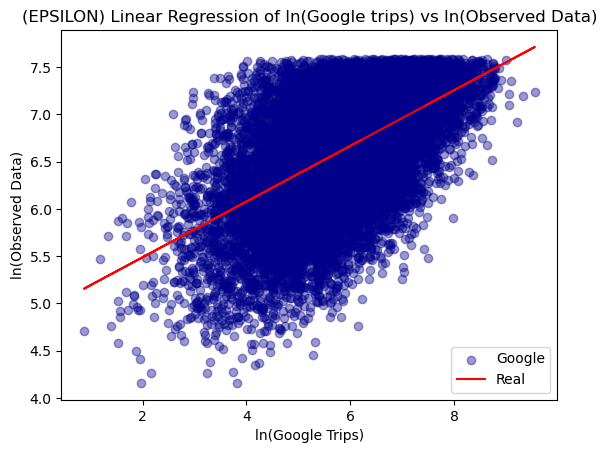

In [203]:
np.random.seed(1)

X = np.log(trip_reg_df["Google"].values)
y = np.log(trip_reg_df["Observed"].values)

X_i = np.array(X).reshape(-1, 1)

# set regression through the origin
model = LinearRegression(fit_intercept=True)
model.fit(X_i, y)
predictions = model.predict(X_i)
score = model.score(X_i, y)
beta = model.coef_[0]
intercept = model.intercept_

residuals = y - predictions
residual_mean = np.mean(residuals)
residual_var = np.var(residuals)
residual_std = np.std(residuals)

error_sd = np.sqrt(residual_var)
errors = np.random.normal(
    loc=residual_mean, scale=residual_std, size=len(residuals))
epsilon = residuals - errors

new_X = X + epsilon
new_X_i = np.array(new_X).reshape(-1, 1)

# Fit linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(new_X_i, y)
new_predictions = model.predict(new_X_i)

# Calculate R-squared and print results
r2 = model.score(new_X_i, y)
new_beta = model.coef_[0]
new_intercept = model.intercept_

new_residuals = y - new_predictions
new_residual_mean = np.mean(new_residuals)
new_residual_var = np.var(new_residuals)
new_residual_std = np.std(new_residuals)
print("Pre Residual Mean", residual_mean)
print("Pre Residual Variance:", residual_var)
print()

print("New Resiudal Mean", new_residual_mean)
print("New Residual Variance:", new_residual_var)
print()
print('Beta:', new_beta)
print('Intercept:', new_intercept)
print("R^2:", r2)

plt.scatter(new_X_i, y, color='darkblue', alpha=0.4)
plt.plot(new_X_i, new_predictions, color='red')
plt.title("(EPSILON) Linear Regression of ln(Google trips) vs ln(Observed Data)")
plt.ylabel("ln(Observed Data)")
plt.xlabel("ln(Google Trips)")
plt.legend(["Google", "Real"], loc="lower right")
plt.show()


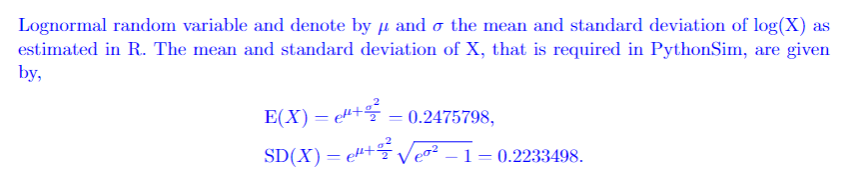

In [204]:
global E_x, SD_X

u = residual_mean
std = np.sqrt(residual_var)
E_x = np.exp(u + ((std**2)/2))
SD_x = np.exp(u + ((std**2)/2)) * np.sqrt(np.exp(std**2) - 1)
print(E_x, SD_x)


1.2047802575019666 0.8095329686143052


### Average Trip Durations between Specific Stations

In [205]:
# Convert the start time and end time to minutes
subset_df['Start Time'] = pd.to_datetime(subset_df['Start Time'])
subset_df['End Time'] = pd.to_datetime(subset_df['End Time'])
subset_df['Start Time (per 30min)'] = (subset_df['Start Time'].dt.hour * 60 + (subset_df['Start Time'].dt.minute // 30) * 30 ) / 30
subset_df['End Time (per 30min)'] = (subset_df['End Time'].dt.hour * 60 + (subset_df['End Time'].dt.minute // 30) * 30 ) / 30

# Group the data by start and end station and 30-minute interval, and calculate the average trip duration in seconds for each group
Station_HalfHour_AvgDuration = subset_df.groupby([subset_df['Start Station Name'], subset_df['Start Station Id'], subset_df['End Station Name'], subset_df['End Station Id'], subset_df['Start Time (per 30min)']])['Trip_Duration'].mean().reset_index(name='Avg_Trip_Duration')

Station_HalfHour_AvgDuration['Avg_Trip_Duration'] = Station_HalfHour_AvgDuration['Avg_Trip_Duration']

# Display the result
avg_trip_duration = Station_HalfHour_AvgDuration.sort_values(by="Start Time (per 30min)")
avg_trip_duration


,Start Station Name,Start Station Id,End Station Name,End Station Id,Start Time (per 30min),Avg_Trip_Duration
662,Bay St / College St (East Side),7006,Fort York Blvd / Capreol Ct,7000.0,0.0,17.850000
740,Bay St / College St (East Side),7006,Union Station,7033.0,0.0,6.716667
2555,Lake Shore Blvd W / Ontario Dr,7242,Marilyn Bell Park Tennis Court,7430.0,0.0,12.270000
2523,Lake Shore Blvd W / Ontario Dr,7242,King St W / Brant St,7322.0,0.0,6.966667
3390,Ontario Place Blvd / Lake Shore Blvd W (East),7171,HTO Park (Queens Quay W),7175.0,0.0,13.033333
...,...,...,...,...,...,...
1848,HTO Park (Queens Quay W),7175,Bay St / Queens Quay W (Ferry Terminal),7016.0,47.0,9.800000
1808,HTO Park (Queens Quay W),7175,Bathurst St/Queens Quay(Billy Bishop Airport),7203.0,47.0,10.491667
1722,Fort York Blvd / Capreol Ct,7000,Soho St / Queen St W,7217.0,47.0,6.466667
4810,Union Station,7033,Bathurst St/Queens Quay(Billy Bishop Airport),7203.0,47.0,20.500000


In [206]:
avg_trip_duration["Avg_Trip_Duration"].describe()


count    5491.000000
mean       14.698271
std         6.855486
min         1.066667
25%         9.150000
50%        14.227778
75%        19.602778
max        33.000000
Name: Avg_Trip_Duration, dtype: float64

# Global Variables

- Decide on the time units
    - Min 

In [207]:
global E_x, SD_X

# Classes

In [215]:
class Station:
    def __init__(self, station_id, level, capacity):
        self.id = station_id
        self.level = level
        self.capacity = capacity
        self.bikes = {}
        self.bike_list = []
        for i in range(level):
            bike_id = f"{station_id}-{i+1}"  # create unique bike ID
            self.bikes[bike_id] = True  # mark bike as available
            self.bike_list.append(bike_id)

    def rent_bike(self):
        # Request a bike from the station
        if self.level > 0:
            if self.bike_list:
                random_index = np.random.randint(0, len(self.bike_list))
                bike_id = self.bike_list.pop(random_index)
                self.level -= 1
                return bike_id
        return None

    def return_bike(self, bike_id):
        # # Return a bike to the station
        if self.level < self.capacity:
            self.bike_list.append(bike_id)
            self.level += 1

    def Get_Bike_List(self):
        return self.bike_list


class Customer:
    def __init__(self, customer_id, start_s_id, bike=None):
        self.customer_id = customer_id
        self.start_s_id = start_s_id
        self.end_s_id = 0
        self.station_level = 0
        self.bike = bike

    def rent_bike(self, T):
        station = StationDict[self.start_s_id]
        print(f"Customer Arrives at S{station.id} with Level: {station.level}")

        if station.level > 0:
            self.bike = station.rent_bike()
            self.station_level = station.level
            print("(Customer Rent Bikes) Customer ID: {} | Bike ID {} || From: S{} -> Remaining Level: {}".format(self.customer_id,
                                                                                                                  self.bike,
                                                                                                                  self.start_s_id,
                                                                                                                  self.station_level))
            #end_s_id = 
            self.Departure(T)
            #return end_s_id
        else:
            print(f"    Customer {self.customer_id} CANNOT RENT BIKE -- EMPTY STATION {self.start_s_id} w/ level {self.station_level} -- EMPTY")
        #return None

    # def return_bike(self, end_station, bike):
    #     destination_station = StationDict[end_station]
    #     destination_station.return_bike(bike)
    #     self.station_level = destination_station.level
        
    def return_bike(self, end_station, bike):
        destination_station = StationDict[end_station]

        if destination_station.level >= destination_station.capacity:
            print(
                f"    Customer {self.customer_id} CANNOT RETURN BIKE -- FULL STATION {destination_station.id} w/ level {destination_station.level} -- FULL")

        else:
            destination_station.return_bike(bike)
            self.station_level = destination_station.level
        
    
    def Departure(self, T):
        self.end_s_id = self.Destination(T=T, retrial=0)
        SimFunctions.Schedule(Calendar, "Bike_Arrival", min(8, self.TripDuration(T)))
        return self.end_s_id
    
    def Destination(self, T, retrial=0):
        end_s_id = None
        while end_s_id is None:
            end_s_id = self.ChoosingRoute(prob_df, start_s_id=self.start_s_id, start_time=T)

        end_station = StationDict[end_s_id]

        if self.bike is None:
            print(" Customer ID: {} Leaves from empty | From: {} -> Remaining Level {}".format(self.customer_id,
                                                                                               self.start_s_id,
                                                                                               self.station_level))
        elif retrial == 1:
            pass

        elif retrial == 0 and self.bike is not None:
            print(" (DEPARTING) Customer ID: {} | Bike ID: {} || From: S{} -> Level {} | To: S{} -> Level {}".format(self.customer_id,
                                                                                                                     self.bike,
                                                                                                                     self.start_s_id,
                                                                                                                     self.station_level,
                                                                                                                     end_station.id,
                                                                                                                     end_station.level))
        return end_s_id
        
######
#HELPER FUNCTIONS
######
    def ChoosingRoute(self, prob_df, start_s_id, start_time):
        retry = None
        try:
            start_row = prob_df.loc[(start_s_id, start_time)]
            probs = start_row.values
            end_s_id = np.random.choice(start_row.index, p=probs)
            return end_s_id
        except KeyError:
            print(
                f"No data found for start station '{start_s_id}' and start time '{start_time}'")
            retry = None
            return retry

    def TripDuration(self, T):
        print(f"Customer ID = {self.customer_id} | T={T} | start_id = {self.start_s_id} | end_id = {self.end_s_id}")
        duration_data = avg_trip_duration[(avg_trip_duration["Start Time (per 30min)"] == T) &
                                          (avg_trip_duration["Start Station Id"] == self.start_s_id) &
                                          (avg_trip_duration["End Station Id"] == self.end_s_id)]["Avg_Trip_Duration"].values[0]
        trip_time = duration_data * SimRNG_Modified.Lognormal(ZSimRNG, E_x, SD_x**2, 4)
        trip_time = min(30, np.round(trip_time))
        return max(2, trip_time)


# Functions

In [216]:
def Start():
    SimFunctions.Schedule(Calendar, "Customer_Arrival", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
    
def NextCustomerID():
    if not hasattr(NextCustomerID, "counter"):
        NextCustomerID.counter = 0
    NextCustomerID.counter += 1
    return NextCustomerID.counter

## Trip Process Functions

In [217]:
def Customer_Arrival_Rate(T):
    temp_df = arrival_df[arrival_df["Start Time (per 30min)"] == T]
    arrival_rates = temp_df["ArrivalRate (per min)"].values
    possible_station_ids = temp_df["Start Station Id"].values
    selected_station_id = np.random.choice(possible_station_ids, p=(arrival_rates / arrival_rates.sum()))
    arrival_rate = arrival_df[(arrival_df["Start Time (per 30min)"] == T) & (arrival_df["Start Station Id"] == selected_station_id)]["ArrivalRate (per min)"].values[0]
    return arrival_rate, selected_station_id

def Customer_Arrival(empty_error, CustomerList, T):
    arrival_rate, station_id = Customer_Arrival_Rate(T)
    mu = 1/arrival_rate
    SimFunctions.Schedule(Calendar, "Customer_Arrival", min(30, np.round(SimRNG_Modified.Expon(ZSimRNG, mu, 1))))
    
    station = StationDict[station_id]
    customer_id = NextCustomerID()
    customer = Customer(customer_id, station_id)
    customer.start_s_id = station_id
    customer.station_level = station.level

################################################################
# STATION EMPTY
################################################################
    if customer.station_level == 0:
        print(f"    EMPTY -- Customer {customer.customer_id} CANNOT RENT BIKE | S{customer.start_s_id} -> level {customer.station_level} -- EMPTY")
        empty_error += 1
    else:
        CustomerList.append(customer)
        customer.rent_bike(T=T)
        
    return empty_error, customer


def Bike_Arrival(Full_Error, CustomerList, temp_customer):
    end_s_id = temp_customer.end_s_id
    if end_s_id != 0:
        end_station = StationDict[end_s_id] 
        
        if end_station.level < end_station.capacity:
            for customer in CustomerList:
                if customer.end_s_id == end_station.id and customer.bike is not None:
                    customer.return_bike(customer.end_s_id, customer.bike)
                    print("     (BIKE RETURNED) Customer ID: {} | Bike ID: {} || To: S{} -> Level {} | From: S{}".format(customer.customer_id,
                                                                                                                            customer.bike,
                                                                                                                            end_station.id,
                                                                                                                            end_station.level,
                                                                                                                            customer.start_s_id
                                                                                                                            ))
                    CustomerList.remove(customer)
                    return Full_Error

    ################################################################
    #STATION FULL
    ################################################################
        else:
            for customer in CustomerList:
                customer_end_station = StationDict[customer.start_s_id]
                if customer.end_s_id == customer_end_station.id and customer_end_station.level >= customer_end_station.capacity:
                    temp_customer = customer
                    print(f"     FULL --  Customer ID: {customer.customer_id} || To: S{end_station.id} -> Level {end_station.level} | Capacity {end_station.capacity} || From: S{customer.start_s_id} | Bike ID: {customer.bike}")
                    Full_Error += 1
                    SimFunctions.Schedule(Calendar, "Retrial", 0.1) # Schedule Retrial instantly
                    Retrial(Full_Error, CustomerList, temp_customer=temp_customer)
                    return Full_Error
                else:
                    pass
    else:
        pass
    
    return Full_Error


def Retrial(Full_Error, CustomerList, temp_customer, T):
    end_s_id = temp_customer.end_s_id
    customer = temp_customer
    for customer in CustomerList:
        customer_end_station = StationDict[customer.start_s_id]
        if customer.end_s_id == customer_end_station.id and customer_end_station.level >= customer_end_station.capacity:
            pre_end_s_id = customer.end_s_id
            start_s_id = customer.start_s_id
            end_s_id = pre_end_s_id
            condition = False

            while not condition:
                if pre_end_s_id == end_s_id or start_s_id == end_s_id:
                    end_s_id = customer.Destination(T, retrial=1)
                else:
                    customer.end_s_id = end_s_id
                    condition = True

            print(
                f"    (NEW STATION) Customer ID: {customer.customer_id} tries new station S{customer.end_s_id}")
            trip_time = customer.TripDuration(T)
            SimFunctions.Schedule(Calendar, "Bike_Arrival", min(30, trip_time))

            return Full_Error
    return Full_Error


# Simulation

In [218]:
NextCustomerID.counter = 0

ZSimRNG = SimRNG_Modified.InitializeRNSeed()

Calendar = SimClasses.EventCalendar()

Queue = SimClasses.FIFOQueue()
Wait = SimClasses.DTStat()
Bikes = SimClasses.Resource()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []

CustomerList = []
Full_Error_list = []
Empty_Error_list = []

MeanTBA = 0.5
MeanTR = 0.5
MeanST = 0.5

Phases = 3
RunLength = 50
WarmUp = 5
end_s_id = 1


for days in range(0, 1, 1):
    Full_Error = 0
    Empty_Error = 0
    Stations = []

    # Initialize the stations and create a dictionary mapping station IDs to Station instances
    unique_stations = np.unique(subset_df["Start Station Id"].values)
    for station in unique_stations:
        r_i = np.random.randint(12, 31)
        x_i = np.random.randint(0, r_i)
        Stations.append(Station(station_id=station, level=x_i, capacity=r_i))

    StationDict = {station.id: station for station in Stations}
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Inital Bike List: {station.Get_Bike_List()}")
        
    SimFunctions.SimFunctionsInit(Calendar, TheQueues, TheCTStats, TheDTStats, TheResources)
    SimFunctions.Schedule(Calendar, "Start", SimRNG_Modified.Expon(ZSimRNG, 0, 1))
        
    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == "Start":
        Start()

    for T in [i for i in range(8,24)]:  # T = hours intervals
        print(f"          Clock Hour | {T}")
        for minutes in [i for i in range(1, 31)]:  # 30 min intervals
            print("             Minute | {}".format(minutes))
            
            NextEvent = Calendar.Remove()
            SimClasses.Clock = NextEvent.EventTime
            
            print(Calendar.N())
            if NextEvent.EventType == "Customer_Arrival":
                Empty_Error, customer = Customer_Arrival(Empty_Error, CustomerList, T)
            
            elif NextEvent.EventType == "Bike_Arrival":
                Full_Error = Bike_Arrival(Full_Error, CustomerList, customer)
            
            elif NextEvent.EventType == "Retrial":
                Full_Error = Retrial(Full_Error, CustomerList, customer, T)
               
    for station_id, station in StationDict.items():
        print(f"Station {station_id} Bike List: {station.Get_Bike_List()}")

    print(f"Num of Full Errors: {Full_Error}")
    print(f"Num of Empty Errors: {Empty_Error}")
    Full_Error_list.append(Full_Error)
    Empty_Error_list.append(Empty_Error)
    print(f"End of Day {days}")
    print("--------------------------------------------------------------------------------------------------------------------------------------------------")


Station 7000 Inital Bike List: ['7000-1', '7000-2']
Station 7006 Inital Bike List: ['7006-1', '7006-2', '7006-3', '7006-4']
Station 7016 Inital Bike List: []
Station 7030 Inital Bike List: ['7030-1', '7030-2']
Station 7033 Inital Bike List: ['7033-1', '7033-2', '7033-3']
Station 7043 Inital Bike List: ['7043-1', '7043-2', '7043-3', '7043-4', '7043-5', '7043-6', '7043-7', '7043-8', '7043-9', '7043-10', '7043-11', '7043-12', '7043-13', '7043-14', '7043-15', '7043-16']
Station 7076 Inital Bike List: ['7076-1']
Station 7078 Inital Bike List: ['7078-1', '7078-2', '7078-3']
Station 7168 Inital Bike List: ['7168-1', '7168-2', '7168-3', '7168-4', '7168-5', '7168-6', '7168-7', '7168-8', '7168-9', '7168-10', '7168-11', '7168-12', '7168-13', '7168-14', '7168-15']
Station 7171 Inital Bike List: ['7171-1', '7171-2', '7171-3', '7171-4', '7171-5', '7171-6', '7171-7']
Station 7175 Inital Bike List: ['7175-1', '7175-2', '7175-3', '7175-4', '7175-5', '7175-6', '7175-7', '7175-8', '7175-9', '7175-10', '7

In [219]:
for station_id, station in StationDict.items():
    print(f"Station {station_id} Bike List: {station.Get_Bike_List()}")
    print(station.level)
    print(station.capacity)
print(f"Num of Full Errors: {Full_Error}")
print(f"Num of Empty Errors: {Empty_Error}")


Station 7000 Bike List: []
0
20
Station 7006 Bike List: ['7006-1', '7322-4']
2
15
Station 7016 Bike List: []
0
24
Station 7030 Bike List: []
0
13
Station 7033 Bike List: ['7006-2', '7043-6']
2
18
Station 7043 Bike List: ['7261-11']
1
18
Station 7076 Bike List: []
0
22
Station 7078 Bike List: ['7078-1', '7006-3']
2
15
Station 7168 Bike List: ['7168-1', '7168-9', '7168-14', '7043-14', '7043-1', '7043-8', '7000-2', '7078-3', '7261-4', '7261-10', '7322-3', '7322-1']
12
21
Station 7171 Bike List: []
0
26
Station 7175 Bike List: ['7175-1', '7175-2', '7175-3', '7175-4', '7175-5', '7298-10', '7261-12', '7043-10', '7242-14', '7175-6', '7298-8', '7006-4', '7430-15', '7171-5', '7171-1']
15
18
Station 7203 Bike List: []
0
15
Station 7217 Bike List: ['7217-2', '7175-10', '7175-7', '7030-2', '7298-7']
5
26
Station 7242 Bike List: ['7242-2', '7242-11', '7242-16', '7242-18', '7242-19', '7242-20', '7168-5', '7168-13']
8
27
Station 7261 Bike List: ['7168-15']
1
25
Station 7298 Bike List: ['7298-1', '729

In [220]:
print(f"Num of Full Errors: {Full_Error_list}")
print(f"Num of Empty Errors: {Empty_Error_list}")

Num of Full Errors: [0]
Num of Empty Errors: [95]


In [214]:
# next_arrival_time = {}  # initialize empty dictionary


# def schedule_next_arrival(station_id, arrival_time):
#     # update next arrival time for the station
#     next_arrival_time[station_id] = arrival_time


# # Example usage
# station_id_1 = 1
# station_id_2 = 2

# arrival_rate_1 = 5  # hypothetical arrival rate for station 1
# arrival_rate_2 = 3  # hypothetical arrival rate for station 2

# # Schedule the first arrival for each station
# mu_1 = 1 / (30 * arrival_rate_1)  # mean inter-arrival time for station 1
# arrival_time_1 = SimRNG_Modified.Expon(ZSimRNG, mu_1, 1)[
#     0]  # generate first arrival time
# schedule_next_arrival(station_id_1, arrival_time_1)
# SimFunctions.Schedule(Calendar, "Customer_Arrival", arrival_time_1)

# mu_2 = 1 / (30 * arrival_rate_2)  # mean inter-arrival time for station 2
# arrival_time_2 = SimRNG_Modified.Expon(ZSimRNG, mu_2, 1)[
#     0]  # generate first arrival time
# schedule_next_arrival(station_id_2, arrival_time_2)
# SimFunctions.Schedule(Calendar, "Customer_Arrival", arrival_time_2)

# # At this point, the first arrivals for both stations have been scheduled. Now we can simulate the subsequent arrivals.

# while SimFunctions.NextEventTime(Calendar) < simulation_end_time:
#     current_time = SimFunctions.NextEventTime(Calendar)

#     # Find the station with the next arrival time
#     next_station_id = min(next_arrival_time, key=next_arrival_time.get)
#     next_arrival_time_for_station = next_arrival_time[next_station_id]

#     # Schedule the next arrival for the selected station
#     if next_arrival_time_for_station <= current_time:
#         schedule_next_arrival(next_station_id, current_time + SimRNG_Modified.Expon(
#             ZSimRNG, 1 / (30 * arrival_rate_for_station), 1)[0])
#         SimFunctions.Schedule(Calendar, "Customer_Arrival",
#                               next_arrival_time_for_station)

#     # Update the number of customers in the system, etc.
#     # ...
